Some good references:
1. https://towardsdatascience.com/a-bunch-of-tips-and-tricks-for-training-deep-neural-networks-3ca24c31ddc8
2. https://towardsdatascience.com/review-densenet-image-classification-b6631a8ef803

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.metrics import cohen_kappa_score
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.densenet import DenseNet121
import keras
import cv2
# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import cv2
import os
from keras.callbacks import Callback
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels
from sklearn.utils import class_weight
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.

['aptos2019-blindness-detection', 'densenet-keras']


Using TensorFlow backend.


In [2]:
# borrowed from https://www.kaggle.com/mathormad/aptos-resnet50-baseline
class QWKCallback(Callback):
    def __init__(self,validation_data):
        super(Callback, self).__init__()
        self.X = validation_data[0]
        self.Y = validation_data[1]
        self.history = []
    def on_epoch_end(self, epoch, logs={}):
        pred = self.model.predict(self.X)
        score = cohen_kappa_score(np.argmax(self.Y,axis=1),np.argmax(pred,axis=1),labels=[0,1,2,3,4],weights='quadratic')
        print("Epoch {} : QWK: {}".format(epoch,score))
        self.history.append(score)
        if score >= max(self.history):
            print('saving checkpoint: ', score)
            self.model.save('../working/Resnet50_bestqwk.h5')
        
        
    

In [3]:
# borrowed from https://github.com/yu4u/mixup-generator
class MixupGenerator():
    def __init__(self, X_train, y_train, batch_size=32, alpha=0.2, shuffle=True, datagen=None):
        self.X_train = X_train
        self.y_train = y_train
        self.batch_size = batch_size
        self.alpha = alpha
        self.shuffle = shuffle
        self.sample_num = len(X_train)
        self.datagen = datagen

    def __call__(self):
        while True:
            indexes = self.__get_exploration_order()
            itr_num = int(len(indexes) // (self.batch_size * 2))

            for i in range(itr_num):
                batch_ids = indexes[i * self.batch_size * 2:(i + 1) * self.batch_size * 2]
                X, y = self.__data_generation(batch_ids)

                yield X, y

    def __get_exploration_order(self):
        indexes = np.arange(self.sample_num)

        if self.shuffle:
            np.random.shuffle(indexes)

        return indexes

    def __data_generation(self, batch_ids):
        _, h, w, c = self.X_train.shape
        l = np.random.beta(self.alpha, self.alpha, self.batch_size)
        X_l = l.reshape(self.batch_size, 1, 1, 1)
        y_l = l.reshape(self.batch_size, 1)

        X1 = self.X_train[batch_ids[:self.batch_size]]
        X2 = self.X_train[batch_ids[self.batch_size:]]
        X = X1 * X_l + X2 * (1 - X_l)

        if self.datagen:
            for i in range(self.batch_size):
                X[i] = self.datagen.random_transform(X[i])
                X[i] = self.datagen.standardize(X[i])

        if isinstance(self.y_train, list):
            y = []

            for y_train_ in self.y_train:
                y1 = y_train_[batch_ids[:self.batch_size]]
                y2 = y_train_[batch_ids[self.batch_size:]]
                y.append(y1 * y_l + y2 * (1 - y_l))
        else:
            y1 = self.y_train[batch_ids[:self.batch_size]]
            y2 = self.y_train[batch_ids[self.batch_size:]]
            y = y1 * y_l + y2 * (1 - y_l)

        return X, y

In [4]:
# borrowed from scikit learn
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes[unique_labels(y_true, y_pred)]
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax


In [5]:
def load_raw_images_df(data_frame,filenamecol,labelcol,img_size,n_classes):
    n_images = len(data_frame)
    X = np.empty((n_images,img_size,img_size,3))
    Y = np.zeros((n_images,n_classes))
    for index,entry in data_frame.iterrows():
        Y[index,entry[labelcol]] = 1 # one hot encoding of the label
        # Load the image and resize
        img = cv2.imread(entry[filenamecol])
        X[index,:] = cv2.resize(img, (img_size, img_size))
        X[index,:] = X[index,:] / 255.0
    return X,Y

In [6]:
batch_size = 32
img_size = 224

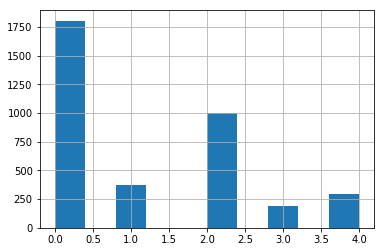

In [7]:
train_raw_data = pd.read_csv("../input/aptos2019-blindness-detection/train.csv")
train_raw_data["filename"] = train_raw_data["id_code"].map(lambda x:os.path.join("../input/aptos2019-blindness-detection/train_images",x+".png"))
train_raw_data.diagnosis.hist() # See the distribution of the classes
# train_raw_data.dtypes

# # train_data["diagnosis"] = train_data["diagnosis"].astype(str)
# # print(train_data.head())
# # print(train_data.diagnosis.unique()) # Look at different types of classes
# # labels = list(map(str,range(5)))
# # print(labels)

In [8]:
label_title = {"0" : "No DR","1" : "Mild","2" : "Moderate","3" :"Severe","4" : "Proliferative DR"}
class_labels=["No DR","Mild","Moderate","Severe","Proliferative DR"]

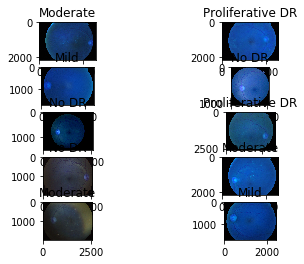

In [9]:
# Display some images
figure, ax = plt.subplots(5,2)
ax = ax.flatten()
for i,row in train_raw_data.iloc[0:10,:].iterrows():
    ax[i].imshow(cv2.imread(os.path.join("../input/aptos2019-blindness-detection/train_images",row["id_code"]+".png")))
    ax[i].set_title(label_title[str(row["diagnosis"])])

In [10]:
train_df,val_df = train_test_split(train_raw_data,random_state=42,shuffle=True,test_size=0.333)
train_df.reset_index(drop=True,inplace=True)
val_df.reset_index(drop=True,inplace=True)

In [11]:
X_train,Y_train = load_raw_images_df(train_df,"filename","diagnosis",img_size,5)
X_val,Y_val = load_raw_images_df(val_df,"filename","diagnosis",img_size,5)


In [12]:
Y_train_labels = np.argmax(Y_train,axis=1)
class_weights = class_weight.compute_class_weight('balanced',np.unique(Y_train_labels),Y_train_labels)
cls_wt_dict = dict(enumerate(class_weights))
print(cls_wt_dict)

{0: 0.40397022332506205, 1: 1.9304347826086956, 2: 0.7333333333333333, 3: 3.7282442748091604, 4: 2.6688524590163936}


In [13]:
datagen = ImageDataGenerator(
            
            zoom_range=0.15,  # set range for random zoom
        # set mode for filling points outside the input boundaries
        fill_mode='constant',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
)
training_generator = MixupGenerator(X_train, Y_train, batch_size=batch_size, alpha=0.2, datagen=datagen)()

In [14]:
def buildModel():
    DenseNet121_model = DenseNet121(include_top=False,weights=None,input_tensor=keras.layers.Input(shape=(img_size,img_size,3)))
    DenseNet121_model.load_weights('../input/densenet-keras/DenseNet-BC-121-32-no-top.h5')
#     model = keras.Sequential()
    
#     model.add(keras.layers.Conv2D(filters = 32, kernel_size = (5,5),padding = 'same',activation ='relu', 
#                       input_shape = (img_size,img_size,3)))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2)))
    
#     model.add(keras.layers.Conv2D(filters = 64, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
#     model.add(keras.layers.Conv2D(filters =96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))

#     model.add(keras.layers.Conv2D(filters = 96, kernel_size = (3,3),padding = 'Same',activation ='relu'))
#     model.add(keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2)))
    
#     model.add(keras.layers.Flatten())
#     model.add(keras.layers.Dense(units = 512, activation = 'relu'))
#     model.add(keras.layers.Dense(units = 5, activation = 'softmax'))
    
    p  = keras.layers.GlobalAveragePooling2D()(DenseNet121_model.output)
#     fl = keras.layers.Flatten()(p)
#     d2 = keras.layers.Dense(units = 1024, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.001))(p)
#     d1 = keras.layers.Dense(units = 512, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.001))(d2)
    d11 = keras.layers.Dense(units = 256, activation = 'relu',kernel_regularizer= keras.regularizers.l2(0.0001))(p)
    o1 = keras.layers.Dense(units = 5, activation = 'softmax')(d11)
    model = keras.models.Model(inputs = DenseNet121_model.input,outputs = o1)
    sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    model.compile(optimizer=sgd,loss='categorical_crossentropy', metrics = ['accuracy'])
    print(model.summary())
    return model

In [15]:
mymodel = buildModel()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

In [16]:
EPOCHS = 50
earlystop = keras.callbacks.EarlyStopping(patience=10)
learning_rate_reduction = keras.callbacks.ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
checkpoint = keras.callbacks.ModelCheckpoint('../working/DenseNet121.h5', monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)
qwk = QWKCallback((X_val,Y_val))
mycallbacks = [earlystop, learning_rate_reduction,checkpoint,qwk]

In [17]:
print(qwk)

In [18]:
# Warm up the model with class weights
EPOCHS = 10
history = mymodel.fit_generator(training_generator,steps_per_epoch = X_train.shape[0] // batch_size,epochs = EPOCHS,
                         validation_data = (X_val,Y_val),
                         validation_steps = 10,
                         workers = 2,use_multiprocessing=True,
                         verbose=2, callbacks=mycallbacks,
                         class_weight=cls_wt_dict)


Epoch 1/10


/opt/conda/lib/python3.6/site-packages/keras/engine/training_generator.py:47: UserWarning: Using a generator with `use_multiprocessing=True` and multiple workers may duplicate your data. Please consider using the`keras.utils.Sequence class.
  UserWarning('Using a generator with `use_multiprocessing=True`'


 - 77s - loss: 1.2478 - acc: 0.6600 - val_loss: 1.9422 - val_acc: 0.3393

Epoch 00001: val_loss improved from inf to 1.94216, saving model to ../working/DenseNet121.h5
Epoch 0 : QWK: 0.43142074210867065
saving checkpoint:  0.43142074210867065
Epoch 2/10
 - 48s - loss: 1.1887 - acc: 0.6600 - val_loss: 1.6007 - val_acc: 0.4828

Epoch 00002: val_loss improved from 1.94216 to 1.60069, saving model to ../working/DenseNet121.h5
Epoch 1 : QWK: 0.6863689179105863
saving checkpoint:  0.6863689179105863
Epoch 3/10
 - 48s - loss: 1.1782 - acc: 0.6612 - val_loss: 1.1044 - val_acc: 0.6787

Epoch 00003: val_loss improved from 1.60069 to 1.10442, saving model to ../working/DenseNet121.h5
Epoch 2 : QWK: 0.6303239737406181
Epoch 4/10
 - 49s - loss: 1.1081 - acc: 0.7068 - val_loss: 0.9549 - val_acc: 0.6844

Epoch 00004: val_loss improved from 1.10442 to 0.95494, saving model to ../working/DenseNet121.h5
Epoch 3 : QWK: 0.6111426952769601
Epoch 5/10
 - 47s - loss: 1.1801 - acc: 0.6579 - val_loss: 1.0209 -

In [20]:
EPOCHS = 10
history = mymodel.fit_generator(training_generator,steps_per_epoch = X_train.shape[0] // batch_size,epochs = EPOCHS,
                         validation_data = (X_val,Y_val),
                         validation_steps = 10,
                         workers = 2,use_multiprocessing=True,
                         verbose=2, callbacks=mycallbacks)

Epoch 1/10


Process ForkPoolWorker-8:
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/opt/conda/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/opt/conda/lib/python3.6/multiprocessing/pool.py", line 119, in worker
    result = (True, func(*args, **kwds))
  File "/opt/conda/lib/python3.6/site-packages/keras/utils/data_utils.py", line 626, in next_sample
    return six.next(_SHARED_SEQUENCES[uid])
  File "<ipython-input-3-f18fa111f7da>", line 19, in __call__
    X, y = self.__data_generation(batch_ids)
  File "<ipython-input-3-f18fa111f7da>", line 43, in __data_generation
    X[i] = self.datagen.random_transform(X[i])
Process ForkPoolWorker-7:
  File "/opt/conda/lib/python3.6/site-packages/keras_preprocessing/image/image_data_generator.py", line 899, in random_transform
    return self.apply_transform(x, params)
  File "/opt/conda/lib/pyth

Epoch 1/10


KeyboardInterrupt: 

In [21]:
mymodel.save_weights("model.h5")

In [22]:
Y_val_pred = mymodel.predict_on_batch(X_val)

In [23]:
Y_val_pred_hot = np.argmax(Y_val_pred,axis=1)
Y_val_actual_hot = np.argmax(Y_val,axis=1)

Confusion matrix, without normalization
[[588   8   0   0   0]
 [ 18  57  41   0   1]
 [ 15  25 276   9   8]
 [  1   0  29  13  19]
 [  2   5  50   5  50]]


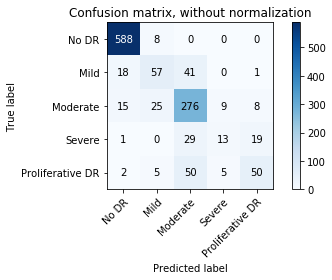

In [24]:
plot_confusion_matrix(Y_val_actual_hot, Y_val_pred_hot, np.array(class_labels))

In [25]:
# history = mymodel.fit_generator(train_gen,steps_per_epoch = 10,epochs = EPOCHS,
#                          validation_data = val_gen,
#                          validation_steps = 10,
#                          workers = 2,use_multiprocessing=True,
#                      verbose=2, callbacks=mycallbacks)
# mymodel.save_weights("model.h5")

In [26]:
# train_gen = img_gen.flow_from_dataframe(
#     dataframe=train_data,
#     directory="../input/aptos2019-blindness-detection/train_images",
#     x_col="filename",
#     y_col="diagnosis",
#     batch_size=batch_size,
#     shuffle=True,
#     class_mode="categorical",
#     classes=labels,
#     target_size=(img_size,img_size),
#     subset='training')

In [27]:
# val_gen = img_gen.flow_from_dataframe(
#     dataframe=train_data,
#     directory="../input/aptos2019-blindness-detection/train_images",
#     x_col="filename",
#     y_col="diagnosis",
#     batch_size=batch_size,
#     shuffle=True,
#     class_mode="categorical",
#     classes=labels,
#     target_size=(img_size,img_size),
#     subset='validation'
# )
# # dir(val_gen)

In [28]:
# class QWK(keras.callbacks.Callback):
#     def on_train_begin(self, logs={}):
#         self.val_kappas = []

#     def on_epoch_end(self, epoch, logs={}):
#         print(self.__dict__)
#         X_val, y_val = self.model.validation_data[:2]
#         y_pred = self.model.predict(X_val)

#         _val_kappa = cohen_kappa_score(
#             y_val.argmax(axis=1), 
#             y_pred.argmax(axis=1), 
#             weights='quadratic'
#         )

#         self.val_kappas.append(_val_kappa)

#         print(f"epoch: {epoch} \t val_kappa: {_val_kappa:.4f}")

#         return
    

In [29]:
# val_gen = img_gen.flow_from_dataframe(
#     dataframe=train_data,
#     directory="../input/aptos2019-blindness-detection/train_images",
#     x_col="filename",
#     y_col="diagnosis",
#     batch_size=1000,
#     shuffle=True,
#     class_mode="categorical",
#     classes=labels,
#     target_size=(img_size,img_size),
#     subset='validation'
# )
# # print(val_gen.batch_index)
# # for i in range(val_gen.batch_index):
# batch_data, batch_labels = val_gen.next()
# batch_labels_arg = np.argmax(batch_labels,axis=1)
# # print(batch_data.shape)

In [30]:
# cur_batch_size = batch_data.shape[0] 
# preds = np.empty((cur_batch_size,5))
# preds_one_hot = np.zeros((cur_batch_size,5))
# for i in range(cur_batch_size):
#     preds[i,:] = mymodel.predict(batch_data[i,:,:,:][np.newaxis,:])
# args_max = np.argmax(preds,axis=1)
# preds_one_hot[np.arange(cur_batch_size),args_max] = 1

In [31]:
# plot_confusion_matrix(batch_labels_arg, args_max, np.array(class_labels))

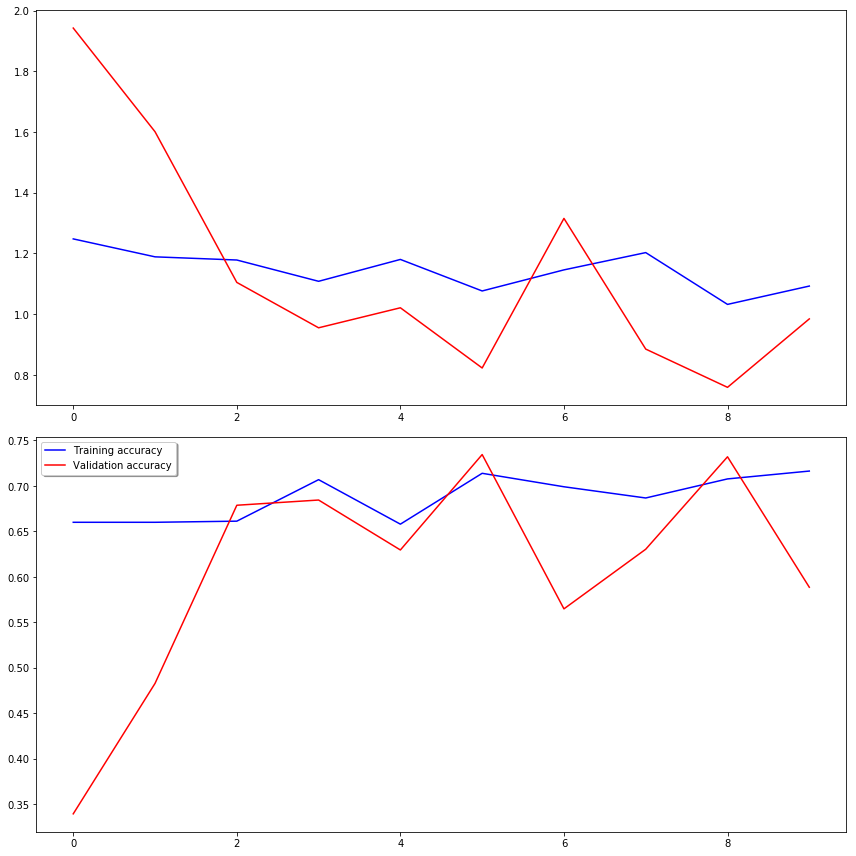

In [32]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
# ax1.set_xticks(np.arange(1, epochs, 1))
# ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
# ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

In [33]:
test_data = pd.read_csv("../input/aptos2019-blindness-detection/test.csv")
test_data["filename"] = test_data["id_code"].map(lambda x:x+".png")
test_data.head()

,id_code,filename
0,0005cfc8afb6,0005cfc8afb6.png
1,003f0afdcd15,003f0afdcd15.png
2,006efc72b638,006efc72b638.png
3,00836aaacf06,00836aaacf06.png
4,009245722fa4,009245722fa4.png


In [34]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(  
        dataframe=test_data,
        directory = "../input/aptos2019-blindness-detection/test_images",    
        x_col="filename",
        y_col=None,
        target_size = (img_size,img_size),
        batch_size = 1,
        shuffle = False,
        class_mode = None
        )

Found 1928 validated image filenames.


In [35]:
predictions = mymodel.predict_generator(test_generator, steps = len(test_generator.filenames))

In [36]:
filenames=test_generator.filenames
results=pd.DataFrame({"id_code":filenames,
                      "diagnosis":np.argmax(predictions,axis=1)})
results['id_code'] = results['id_code'].map(lambda x: str(x)[:-4])
results.to_csv("submission.csv",index=False)

<a href="submission.csv">submission.csv</a>

array([0, 2, 4])

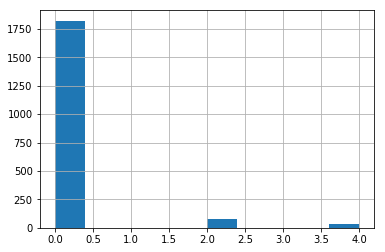

In [37]:
results.diagnosis.hist()
results.diagnosis.unique()